## Using RNN to perform binary addition

In [1]:
!which python

/Users/Bhavesh/anaconda/bin/python


In [20]:
from __future__ import division

import numpy as np
np.random.seed(0)

import copy

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

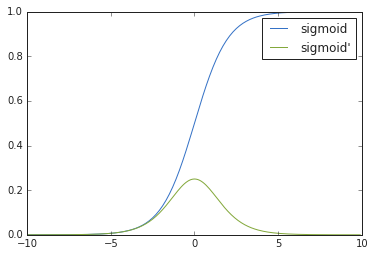

In [21]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return x*(1-x)

# test sigmoid and sigmoid prime
x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, sigmoid_prime(sigmoid(x)), label="sigmoid'")
plt.legend()

In [32]:
"""
Generate our training set using dictionary:
{
    0: [0,0,0,0,0,0,0,0],
    1: [0,0,0,0,0,0,0,1], ...
}
"""
int2binary = {}
binary_dim = 8

largest_number = pow(2, binary_dim)
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis=1)

for i in range(largest_number):
    int2binary[i] = binary[i]

In [33]:
int2binary

{0: array([0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 1: array([0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8),
 2: array([0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8),
 3: array([0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8),
 4: array([0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8),
 5: array([0, 0, 0, 0, 0, 1, 0, 1], dtype=uint8),
 6: array([0, 0, 0, 0, 0, 1, 1, 0], dtype=uint8),
 7: array([0, 0, 0, 0, 0, 1, 1, 1], dtype=uint8),
 8: array([0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8),
 9: array([0, 0, 0, 0, 1, 0, 0, 1], dtype=uint8),
 10: array([0, 0, 0, 0, 1, 0, 1, 0], dtype=uint8),
 11: array([0, 0, 0, 0, 1, 0, 1, 1], dtype=uint8),
 12: array([0, 0, 0, 0, 1, 1, 0, 0], dtype=uint8),
 13: array([0, 0, 0, 0, 1, 1, 0, 1], dtype=uint8),
 14: array([0, 0, 0, 0, 1, 1, 1, 0], dtype=uint8),
 15: array([0, 0, 0, 0, 1, 1, 1, 1], dtype=uint8),
 16: array([0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 17: array([0, 0, 0, 1, 0, 0, 0, 1], dtype=uint8),
 18: array([0, 0, 0, 1, 0, 0, 1, 0], dtype=uint8),
 19: array([0, 0, 0, 1, 0, 0, 1, 1], dtyp

In [31]:
# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

# initialize the network weights
w_0 = 2*np.random.random((input_dim, hidden_dim)) - 1
w_1 = 2*np.random.random((hidden_dim, output_dim)) - 1
w_h = 2*np.random.random((hidden_dim, hidden_dim)) - 1

w_0_update = np.zeros_like(w_0)
w_1_update = np.zeros_like(w_1)
w_h_update = np.zeros_like(w_h)

In [35]:
# training
for j in range(10000):
    
    # adding 2 random number
    a_int = np.random.randint(largest_number/2)
    b_int = np.random.randint(largest_number/2)
    c_int = a_int + b_int
    
    a = int2binary[a_int]
    b = int2binary[b_int]
    c = int2binary[c_int]
    
    # predicted output (initialize to 0)
    d = np.zeros_like(c)
    
    overallError = 0
    
    layer_2_deltas = []
    layer_1_values = []
    layer_1_values.append(np.zeros(hidden_dim))
    
    for position in range(binary_dim):
        
        # input and output
        X = np.array([[a[binary_dim - position - 1], b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T
        
        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X, w_0) + np.dot(layer_1_values[-1], w_h))
        
        # output layer
        layer_2 = sigmoid(np.dot(layer_1, w_1))
        
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error) * sigmoid_prime(layer_2))
        overallError += np.abs(layer_2_error[0])
        
        # decode the predicted output
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position], b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        layer_2_delta = layer_2_deltas[-position-1]
        
        layer_1_delta = (future_layer_1_delta.dot(w_h.T) +
                        layer_2_delta.dot(w_1.T)) * sigmoid_prime(layer_1)
        
        w_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        w_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        w_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    
    w_0 += w_0_update * alpha
    w_1 += w_1_update * alpha
    w_h += w_h_update * alpha
    
    w_0_update *= 0
    w_1_update *= 0
    w_h_update *= 0
    
    if (j%500 == 0):
        print("Error: "+str(overallError))
        print("Pred: "+str(d))
        print("True: "+str(c))
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out))
        print("-----------------")

Error: [ 3.95984093]
Pred: [1 1 0 1 1 1 0 0]
True: [1 0 1 1 0 1 1 1]
72 + 111 = 220
-----------------
Error: [ 3.97406774]
Pred: [1 1 1 1 1 0 1 0]
True: [1 1 0 0 0 1 1 0]
89 + 109 = 250
-----------------
Error: [ 3.83035052]
Pred: [0 0 0 0 1 1 1 1]
True: [0 0 1 0 1 0 1 0]
3 + 39 = 15
-----------------
Error: [ 3.90470272]
Pred: [0 0 0 0 0 0 1 0]
True: [0 1 0 1 0 1 1 0]
5 + 81 = 2
-----------------
Error: [ 3.67901258]
Pred: [1 1 0 1 0 0 1 0]
True: [1 0 0 0 0 0 1 0]
57 + 73 = 210
-----------------
Error: [ 2.87537112]
Pred: [0 0 0 0 1 0 0 0]
True: [0 0 1 0 0 0 1 0]
20 + 14 = 8
-----------------
Error: [ 2.48982914]
Pred: [1 0 1 0 1 0 0 1]
True: [1 0 1 0 1 0 0 1]
65 + 104 = 169
-----------------
Error: [ 1.23508642]
Pred: [0 0 1 0 1 1 0 0]
True: [0 0 1 0 1 1 0 0]
36 + 8 = 44
-----------------
Error: [ 1.82459631]
Pred: [1 1 1 0 1 0 1 1]
True: [1 1 1 0 1 0 1 1]
110 + 125 = 235
-----------------
Error: [ 1.29017042]
Pred: [1 1 0 1 0 0 0 1]
True: [1 1 0 1 0 0 0 1]
98 + 111 = 209
-----------